## Notebook to analyse manual lesion masks

In [43]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import ptitprince as pt
import seaborn as sns

# Get lesion masks

In [44]:
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
        """cluster predictions and threshold based on min_area_threshold

        Args:
            mask: boolean mask of the per-vertex lesion predictions to cluster"""
        n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
        islands = np.zeros(len(mask))
        # only include islands larger than minimum size.
        for island_index in np.arange(n_comp):
            include_vec = labels == island_index
            size = np.sum(include_vec)
            if size >= min_area_threshold:
                island_count += 1
                island_mask = mask.copy()
                island_mask[mask] = include_vec
                islands[island_mask] = island_count
        return islands

In [45]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5', 
                    dataset='MELD_dataset_V6.csv')

patients = cohort.get_subject_ids(group='patient', lesional_only=True )

print(len(patients))


538


In [46]:

df = pd.DataFrame()

for subject in patients:
    values = {}
    values['ID'] = subject
    subj = MeldSubject(subject, cohort)
    
    #add info about MRI status
    values['MRI-negative'] = subj.get_demographic_features('Ever reported MRI negative')
    
    # get lesional hemisphere
    hemi = subj.get_lesion_hemisphere()
    values['hemi'] = hemi
    
    # load lesion
    labels = subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:]
        
    # get lesion size
    mask = (labels>0).astype(bool)
    values['lesion_size'] = mask.sum()
        
    # cluster lesion
    labels_clust = cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0)
    values['n_cluster'] = len(set(labels_clust))-1
    
    for cl in set(labels_clust):
        if cl !=0:
            size_cl = (labels_clust==cl).sum()
            values[f'size_cluster_{cl}'] = size_cl
        
    
    # add info into dataframe
    df = pd.concat([df, pd.DataFrame([values])])
    
    

In [47]:
df

,ID,MRI-negative,hemi,lesion_size,n_cluster,size_cluster_1.0,size_cluster_2.0,size_cluster_3.0,size_cluster_4.0,size_cluster_5.0,size_cluster_6.0,size_cluster_7.0,size_cluster_8.0,size_cluster_9.0,size_cluster_10.0
0,MELD_H12_3T_FCD_0001,1.0,rh,1411,1,1411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0002,1.0,lh,1131,1,1131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0003,0.0,lh,3861,2,3859,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0004,1.0,lh,2293,1,2293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0005,1.0,rh,27595,2,27592,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MELD_H18_3T_FCD_0109,0.0,lh,3886,2,3885,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H18_3T_FCD_0111,0.0,rh,2459,2,2380,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H18_3T_FCD_0115,0.0,rh,2131,1,2131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H18_3T_FCD_0122,0.0,lh,6563,9,6299,233.0,5.0,14.0,5.0,3.0,2.0,1.0,1.0,NaN


In [114]:
len(df[df['n_cluster']>1])

300

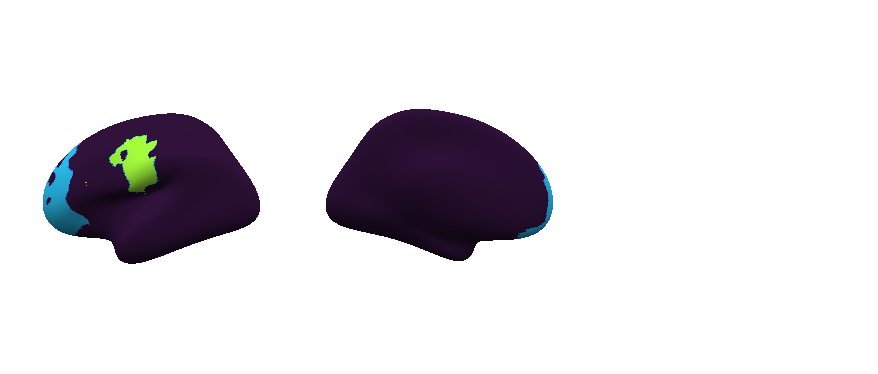

In [111]:
# look at one example

subject = 'MELD_H18_3T_FCD_0122'
# subject = 'MELD_H21_3T_FCD_0011'
subject = 'MELD_H4_3T_FCD_0014'
subj = MeldSubject(subject, cohort)
hemi = subj.get_lesion_hemisphere()
labels = subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:]
mask = (labels>0).astype(bool)
labels_clust = cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0)
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],labels_clust, cmap='turbo', colorbar=False)

Text(0, 0.5, 'Number of patients')

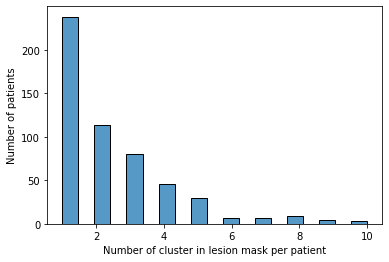

In [102]:
# plot cluster number in lesion mask 

sns.histplot(x='n_cluster', data=df)
plt.xlabel('Number of cluster in lesion mask per patient')
plt.ylabel('Number of patients')


number of cluster above 100:
59


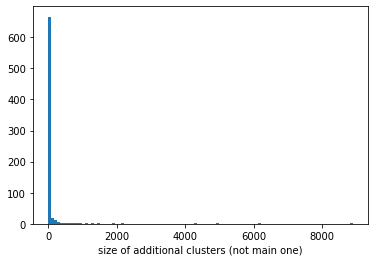

In [105]:
# size of clusters that are not the main one

df_side_cl = df[[f'size_cluster_{x}.0' for x in range(2,10)]]
size_side_cl = df_side_cl.values.flatten()
plt.hist(size_side_cl, bins=100)
plt.xlabel('size of additional clusters (not main one)')

print('number of cluster above 100:')
print((size_side_cl > 100).sum())



In [32]:
df_side_cl

,size_cluster_1,size_cluster_2,size_cluster_3,size_cluster_4,size_cluster_5,size_cluster_6,size_cluster_7,size_cluster_8,size_cluster_9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,233.0,5.0,14.0,5.0,3.0,2.0,1.0,1.0,NaN


Text(0.5, 1.0, 'Mann-Whitney test: stat=28532.0, p=0.04')

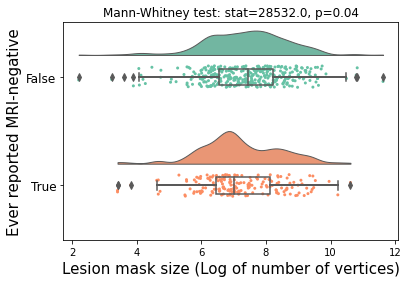

In [100]:
# plot biggest cluster size in MRI-negative vs MRI-positive

import scipy.stats as stats

df['log_cluster'] = np.log(df['size_cluster_1.0'])
pt.RainCloud(x='log_cluster', y='MRI-negative',  data=df, bw= .2, cut=0, orient='horizontal',  scale="area", order=[0,1],
            width_viol=.6, jitter = 0.1, dodge=False)

plt.xlabel('Lesion mask size (Log of number of vertices)', fontsize=15)
plt.ylabel('Ever reported MRI-negative', fontsize=15)
# plt.xticks(, ['False', 'True'], fontsize=12)
# range_log = np.linspace(1,10,10)
# range_orig = [int(np.exp(x)) for x in range_log]
# plt.xticks(range_log, range_orig)
plt.yticks([0, 1], ['False', 'True'], fontsize=12)

stat = stats.mannwhitneyu(df[df['MRI-negative']==1]['size_cluster_1.0'].values, df[df['MRI-negative']==0]['size_cluster_1.0'].values)
#stats.ttest_ind(df[df['MRI-negative']==1]['log_cluster'].values, df[df['MRI-negative']==0]['log_cluster'].values)
plt.title(f'Mann-Whitney test: stat={round(stat[0],2)}, p={round(stat[1],2)}')




AttributeError: 'XAxis' object has no attribute 'get_xticks'

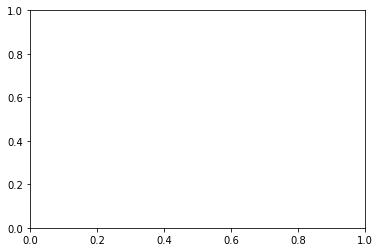

In [97]:
plt.gca().axes.xaxis.get_xticks()

0     1411
0     1131
0     3859
0     2293
0    27592
     ...  
0     3885
0     2380
0     2131
0     6299
0      779
Name: size_cluster_1.0, Length: 538, dtype: int64

In [78]:
plt.axes.get_xticklabels(minor=False, which=None)


AttributeError: 'function' object has no attribute 'get_xticklabels'